## Notebook for Fig. 1 of the paper

First we load the PMM data, i.e. the saved PMM model parameters, and then define E_pred which is the PMM's prediction for the neutron matter EOS

In [1]:
import numpy as np
from PMM import PMM
import matplotlib.pyplot as plt
import pickle 
from tqdm import tqdm

emulator_12 = PMM(np.loadtxt('PMM/12.dat'))
emulator_16 = PMM(np.loadtxt('PMM/16.dat'))
emulator_20 = PMM(np.loadtxt('PMM/20.dat'))
emulator_24 = PMM(np.loadtxt('PMM/24.dat'))
emulator_28 = PMM(np.loadtxt('PMM/28.dat'))
emulator_32 = PMM(np.loadtxt('PMM/32.dat'))

n_data = np.array([0.12,0.16,0.20,0.24,0.28,0.32])

def E_pred(c1_sample,c3_sample):

    E_data = np.array([  emulator_12.E_pred(c1_sample,c3_sample),emulator_16.E_pred(c1_sample,c3_sample),
                         emulator_20.E_pred(c1_sample,c3_sample),emulator_24.E_pred(c1_sample,c3_sample),
                         emulator_28.E_pred(c1_sample,c3_sample),emulator_32.E_pred(c1_sample,c3_sample)  ])
    
    
    return E_data

This cell loads third-order MBPT data for validating the PMM

In [2]:
g  = np.loadtxt('PMM/MBPT_O3.txt')
c1 = g[:,0]
c3 = g[:,1]
E  = g[:,3]

n_train = 30

c1_val = c1[n_train:]
c3_val = c3[n_train:]
E_val = E[n_train:]

We then compute the Percentage Uncertainty (PU) for each of the 70 validation samples

In [3]:
PU = []

for i in range(70):
    PU.append(  np.abs((E_val[i] -  E_pred(c1_val[i],c3_val[i])[1])/E_val[i]*100)   )


This cell loads the neural networks which predict the solutions to the TOV equations

In [4]:
file = open('ML_files/MLP_scaler_s1.pickle', 'rb')
scaler_X = pickle.load(file)   
file.close()

file = open('ML_files/MLP_scaler_y_s1.pickle', 'rb')
scaler_y = pickle.load(file)   
file.close()

file = open('ML_files/MLP_s1.pickle', 'rb')
MLP_regr = pickle.load(file)
#MLP_regr.n_jobs = 1
file.close()

We load the validation data for the 5 parameter model (Set 1)

In [5]:
f_val = np.load('samples/set_1_validation.npz')
NS_val = f_val['NS']
params_val = f_val['params']


The following two cells use the neural networks and the validation data to compute the percentage uncertainty for the neural network emulator (PU_NN)

In [6]:
M_grid = np.linspace(1,2,num=30)

n_samples_val = 100000

x_test = []

y_true_14 = []

for i in (range(n_samples_val)):
    
    M = NS_val[i][1,:]
    L = NS_val[i][2,:]
    
    L = L[M>0]
    M = M[M>0]
    
    if np.amax(M) < 2.0:
        continue
    
    
    x_test.append( params_val[i]  )

    y_true_14.append( np.interp(1.4,M, np.log10(L)) )
        

y_pred = np.array( scaler_y.inverse_transform(  MLP_regr.predict(scaler_X.transform(x_test))) ) 

y_true_14 = 10**np.array(y_true_14)

In [7]:
PU_NN = []

for i in range(len(y_true_14)):
    temp = 10**np.interp(1.4,M_grid, (y_pred[i]))
    
    PU_NN.append(  np.abs((temp-y_true_14[i])/y_true_14[i]*100)  )
    

We then plot the final results. The plot will be saved in the figures folder

100%|███████████████████████████████████| 60488/60488 [00:09<00:00, 6331.14it/s]


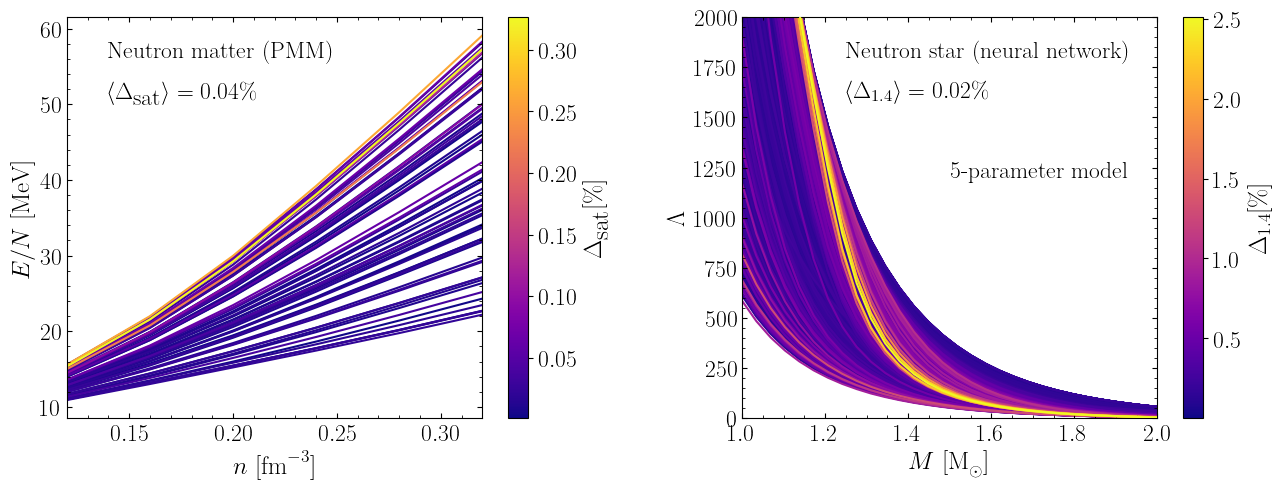

In [8]:
from matplotlib import cm, colors
import matplotlib
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(ncols=2,figsize=(13,5))
cmap = plt.get_cmap("plasma")

fontsize = 18

norm = colors.Normalize(np.amin(PU), np.amax(PU))   

for i in range(70):   
    ax[0].plot( n_data, E_pred(c1_val[i],c3_val[i]),color=cmap(norm(PU[i])) ,zorder=PU[i] )  
    
s = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[0])  
s.ax.set_ylabel(r'$\Delta_\textrm{sat} [\%]$',fontsize=fontsize)
s.ax.tick_params(labelsize=fontsize-1) 


ax[0].set_xlabel(r'$n \ \textrm{[fm}^{-3}\textrm{]}$',fontsize=fontsize)
ax[0].set_ylabel(r'$E/N \ \textrm{[MeV]}$',fontsize=fontsize)

ax[0].text(0.1,0.9,r'\textrm{Neutron matter (PMM)}',fontsize=fontsize-1,transform = ax[0].transAxes)
ax[0].text(0.1,0.8,r'$\langle \Delta_\textrm{sat} \rangle = 0.04 \%$',fontsize=fontsize-1,transform = ax[0].transAxes)

norm = colors.Normalize(np.amin(PU_NN), np.amax(PU_NN))   

for i in tqdm(range(len(y_true_14))[:]):   
    ax[1].plot( M_grid, 10**y_pred[i],color=cmap(norm(PU_NN[i])) ,zorder=PU_NN[i] )  
    
s = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[1])  
s.ax.set_ylabel(r'$\Delta_{1.4} [\%]$',fontsize=fontsize)
s.ax.tick_params(labelsize=fontsize-1) 

ax[1].set_xlabel(r'$M \ \textrm{[M}_\odot$\textrm{]}',fontsize=fontsize)
ax[1].set_ylabel(r'$\Lambda$',fontsize=fontsize)

ax[0].set_xlim(left = 0.12, right = 0.32)

ax[1].set_ylim(top=2000,bottom=0)
ax[1].set_xlim(left = 1, right = 2)

ax[0].minorticks_on()
ax[1].minorticks_on()

ax[0].tick_params(axis='both',which='both',direction='in',bottom=True,top=True,left=True,right=True,labelsize=fontsize-1)
ax[1].tick_params(axis='both',which='both',direction='in',bottom=True,top=True,left=True,right=True,labelsize=fontsize-1)

ax[1].text(0.25,0.9,r'\textrm{Neutron star (neural network)}',fontsize=fontsize-1,transform = ax[1].transAxes)
ax[1].text(0.25,0.8,r'$\langle \Delta_{1.4} \rangle = 0.02 \%$',fontsize=fontsize-1,transform = ax[1].transAxes)
ax[1].text(0.5,0.6,r'$\textrm{5-parameter model}$',fontsize=fontsize-1,transform = ax[1].transAxes)

plt.tight_layout()

plt.subplots_adjust(wspace=0.3)

plt.savefig('figures/emulators.pdf',bbox_inches='tight')


Finally, the next two cells extract and save the figure's source data

In [9]:
with open('source_data/fig1_left_panel.txt', 'w') as f:
    for i, line in enumerate(ax[0].get_lines(), start=1):
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        
        f.write(f'Line {i}:\n')
        f.write('X\tY\n')
        for x, y in zip(x_data, y_data):
            f.write(f'{x}\t{y}\n')
        f.write('\n')  

In [10]:
with open('source_data/fig1_right_panel.txt', 'w') as f:
    for i, line in enumerate(ax[1].get_lines(), start=1):
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        
        f.write(f'Line {i}:\n')
        f.write('X\tY\n')
        for x, y in zip(x_data, y_data):
            f.write(f'{x}\t{y}\n')
        f.write('\n')  